This notebook contains a pipeline to visualize and rebalance the room impulse response dataset used for training. It will eventually drop some examples and double others as a matter of uniform distribution among predicted values.

In [1]:
%cd ..

/home/pcallens/room-acoustics-characterization


In [2]:
import pandas as pd
from utils.acoustic_utils import *
from subprocess import run
from utils.resample import *
import shutil

# Plot and clean RIR dataset

In [31]:
rir_dir = 'datasets/ACE_adapted//raw/'

print('resampling RIR directory')
rir_dir = resample_audio_dir(rir_dir)

print('trimming start of rir directory')
rir_dir = trim_silence_dir(rir_dir)


  6%|▋         | 6/94 [00:00<00:01, 57.31it/s]

resampling RIR directory
------- Resampling directory : datasets/thesis/test/rir/raw/ -------
trimming start of rir directory


100%|██████████| 94/94 [00:01<00:00, 67.96it/s]


In [32]:
def analyse_rir_dir(rir_dir,plot = True):
    rir_dataset = pd.DataFrame(columns = ['RIR_name','t60','c50','drr'])
    for rir_file in tqdm.tqdm(glob.glob(os.path.join(rir_dir, '*'))):
        rir_sr , rir = wavfile.read(rir_file)
        name = os.path.basename(rir_file)
        t60 = t60_impulse_avg(rir,rir_sr)
        drrs = drr_impulse(rir,rir_sr)
        c50 = clarity_avg(50,rir,rir_sr)

        new_row = {'RIR_name' : name,
                   't60' : t60,
                   'c50' : c50,
                   'drr' : drrs}
        rir_dataset = rir_dataset.append(new_row,ignore_index=True)
    if plot:
        rir_dataset.hist(figsize=(20,15),bins=50)
    return rir_dataset


100%|██████████| 94/94 [00:00<00:00, 96.25it/s]


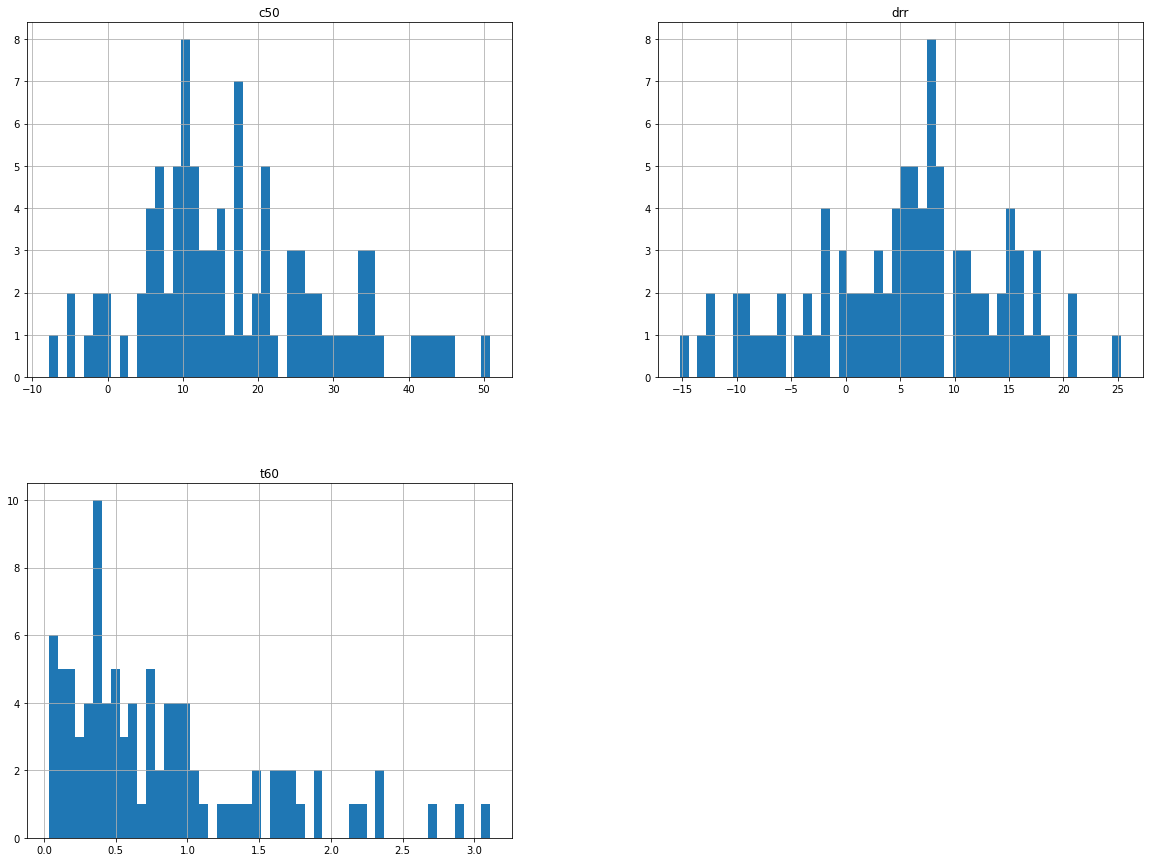

In [33]:
rir_dataset = analyse_rir_dir(rir_dir)

In [6]:
#Balance dataset

rir_high = rir_dataset[rir_dataset['t60']>1.07]
rir_high = rir_high[rir_high['t60']<2.5]

#rir_high = rir_high.sample(frac=1.8,replace=True, random_state = 1)

rir_very_high = rir_dataset[rir_dataset['t60']>2.5]
rir_very_very_high = rir_dataset[rir_dataset['t60']>3]
enhanced_very_high = rir_very_high.sample(frac=3, replace=True, random_state=1)
rir_low = rir_dataset[rir_dataset['t60']<=1.07]
reduced_low = rir_low.sample(frac=0.4, replace=False, random_state=1)
rir_balanced = pd.concat([reduced_low,rir_high,enhanced_very_high,rir_very_very_high])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ce4fe7fd0>,
      dtype=object)

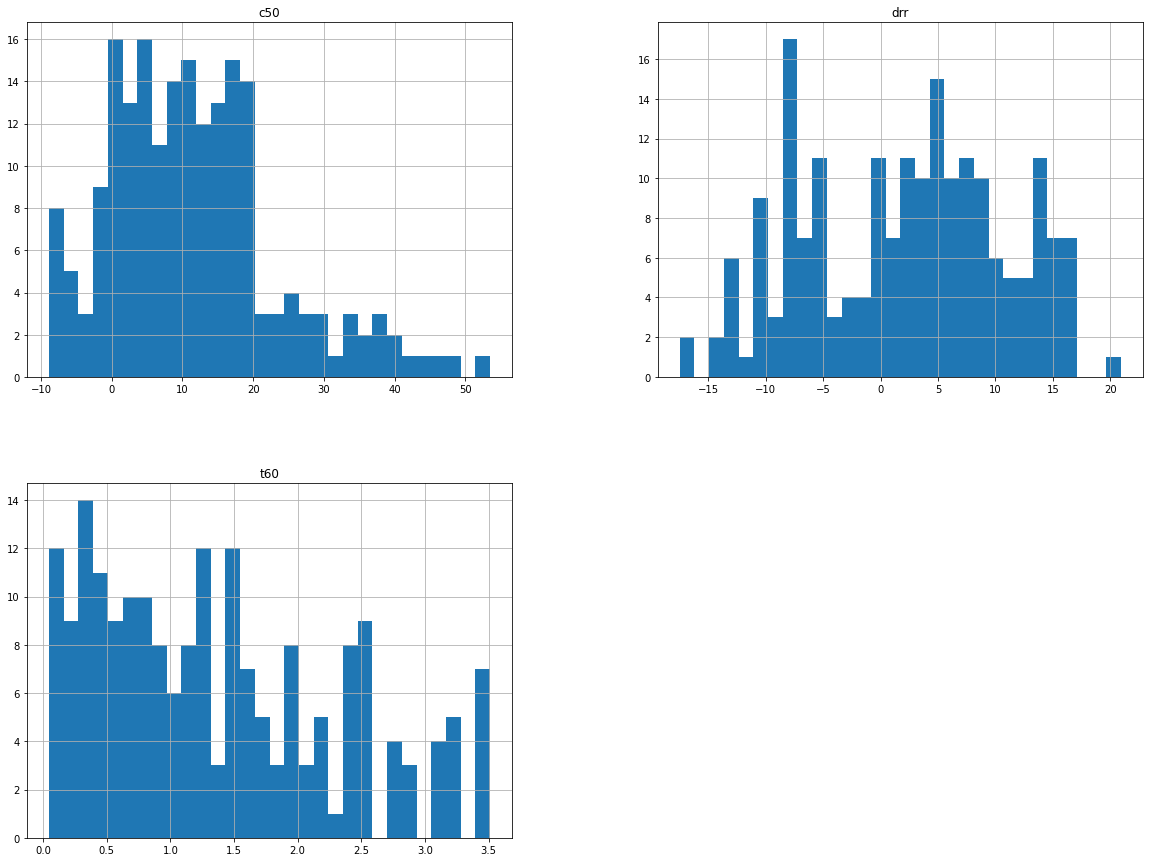

In [7]:
rir_balanced.hist(figsize=(20,15),bins=30)

In [8]:
list_rir_balanced = sorted(rir_balanced.RIR_name.values)

In [9]:
balanced_dir = os.path.join(os.path.dirname(os.path.normpath(rir_dir)),'rir_balanced')
if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)
os.makedirs(balanced_dir) 

In [10]:
for i,rir in enumerate(sorted(list_rir_balanced)):    
    run(['cp', os.path.join(rir_dir, rir), balanced_dir])
    run(['mv', os.path.join(balanced_dir,rir), os.path.join(balanced_dir,str(i)+'_'+rir)])

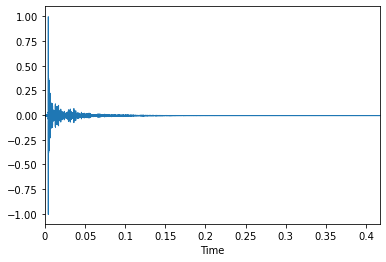

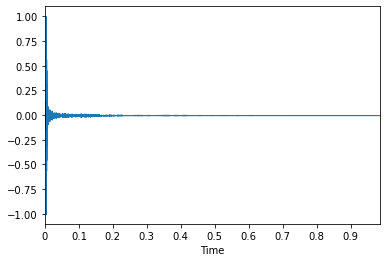

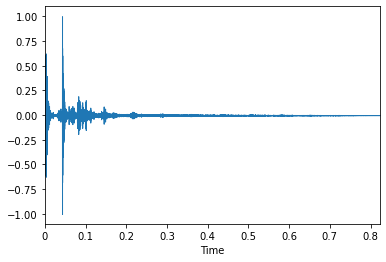

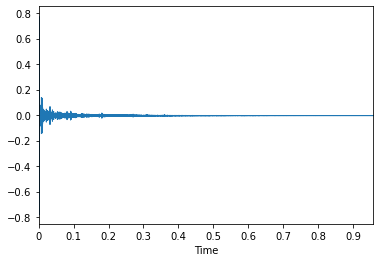

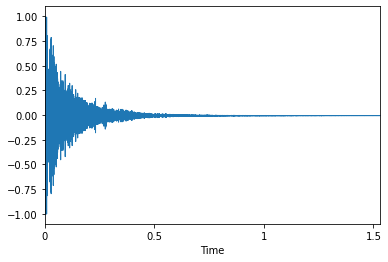

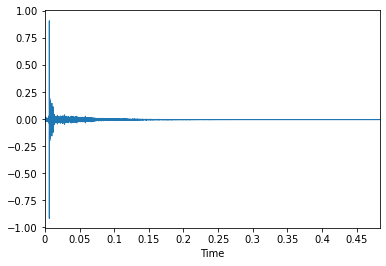

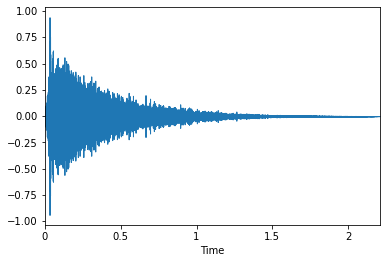

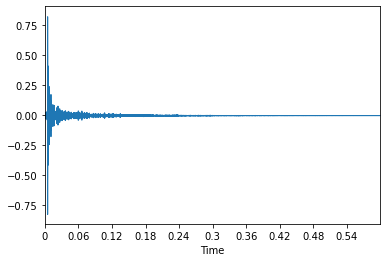

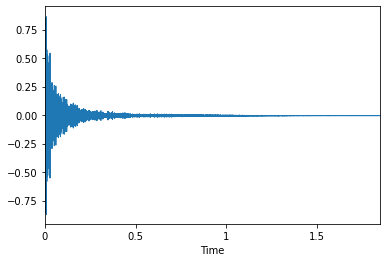

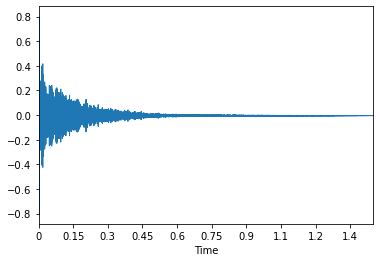

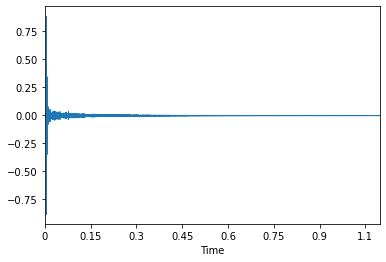

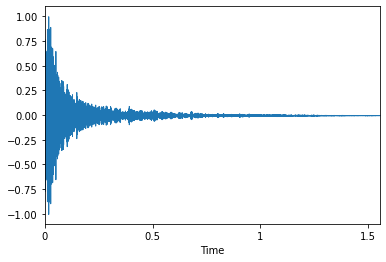

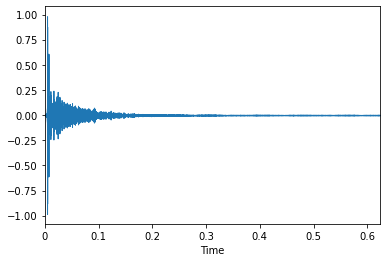

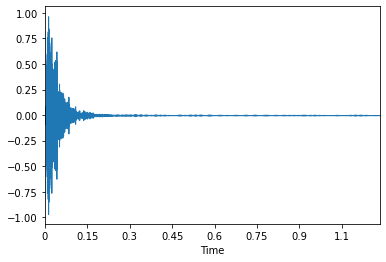

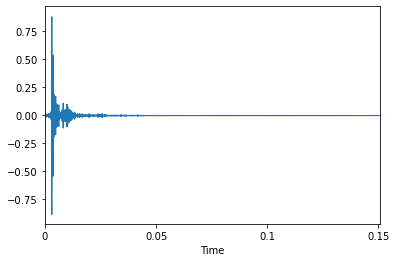

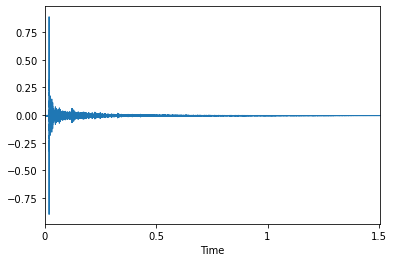

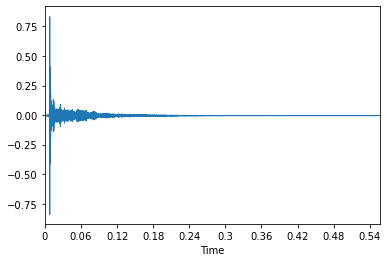

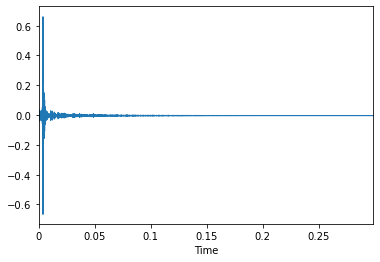

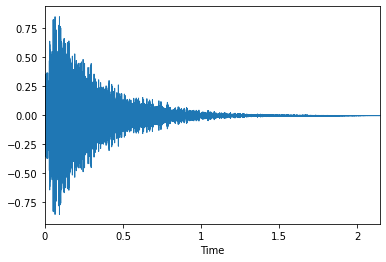

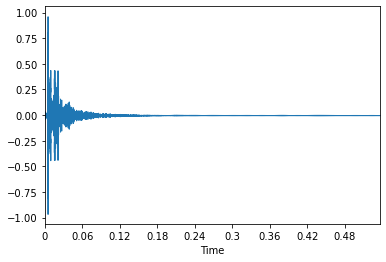

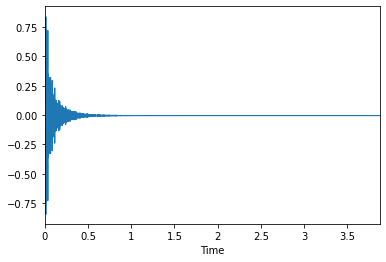

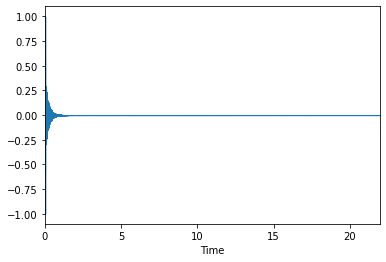

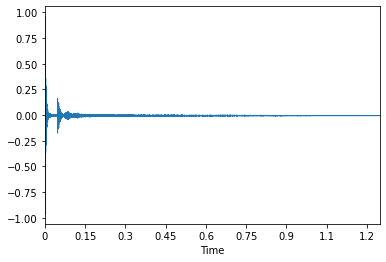

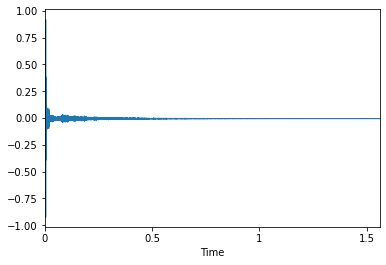

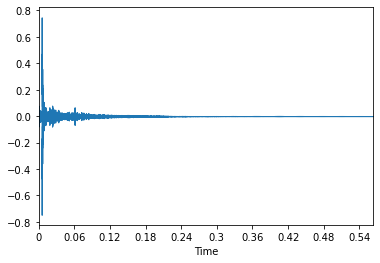

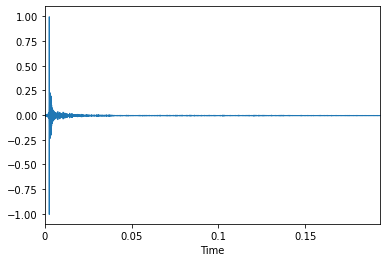

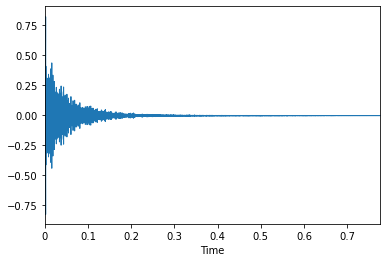

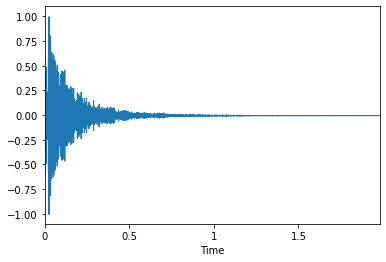

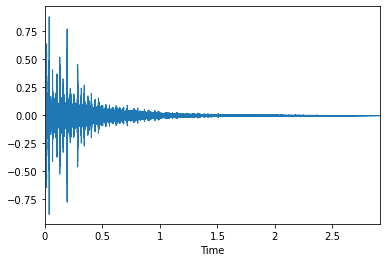

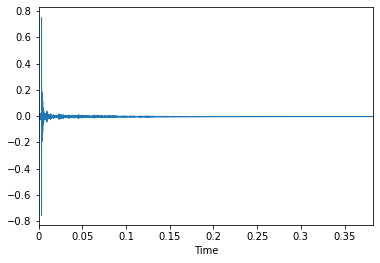

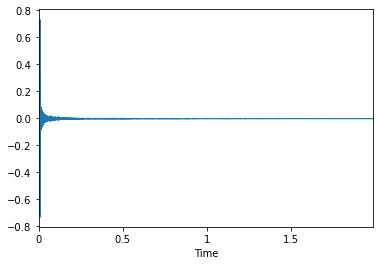

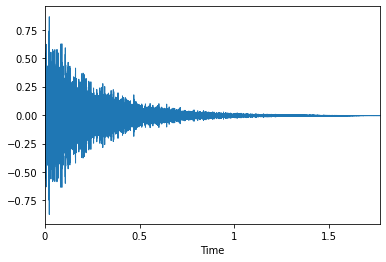

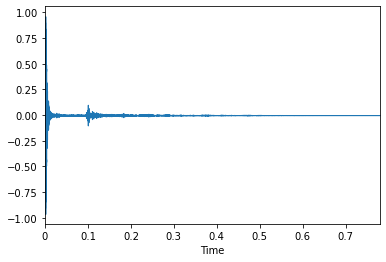

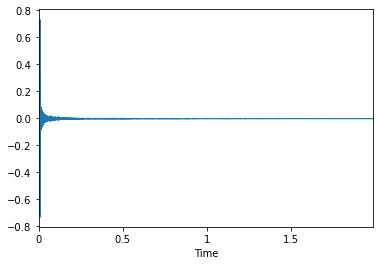

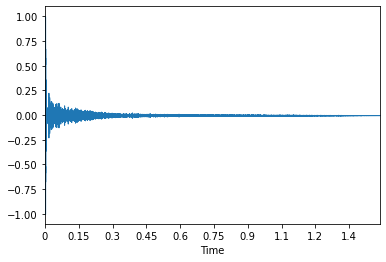

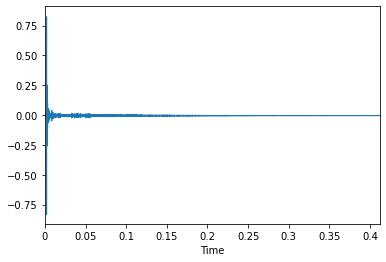

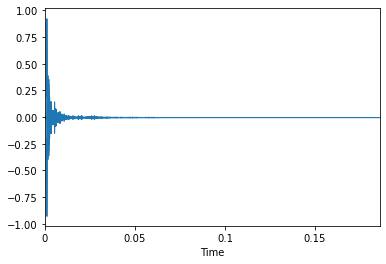

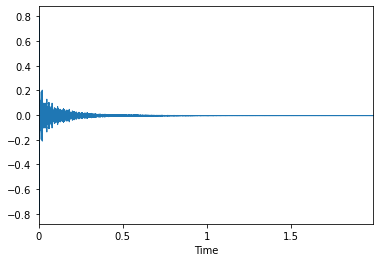

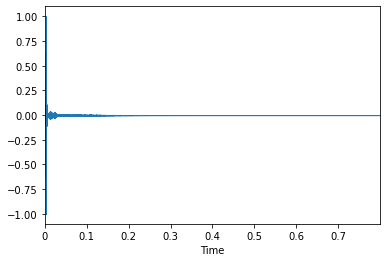

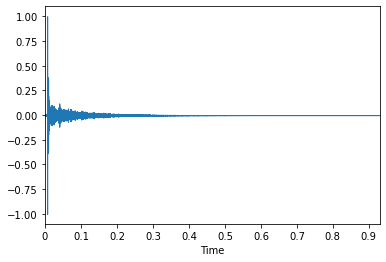

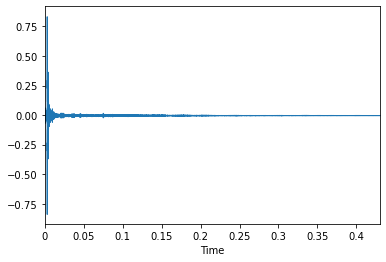

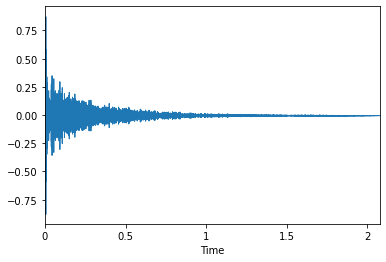

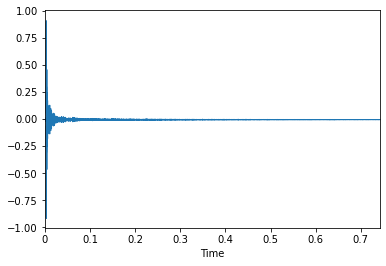

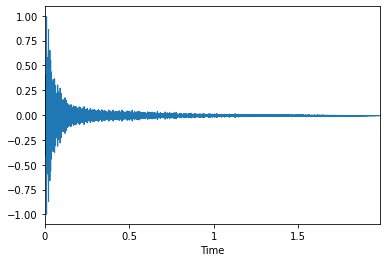

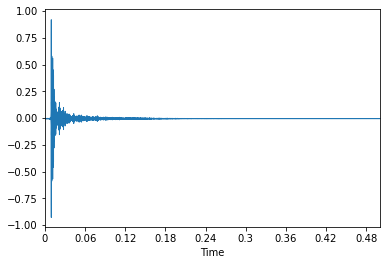

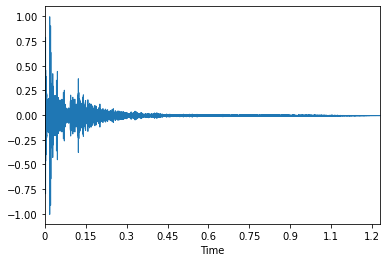

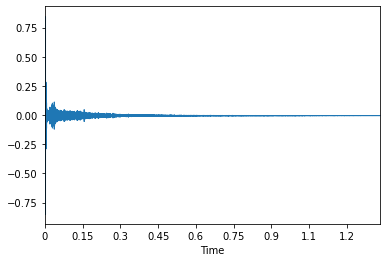

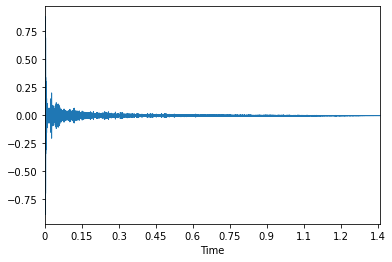

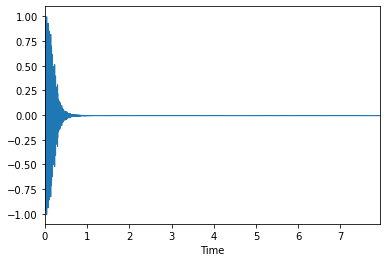

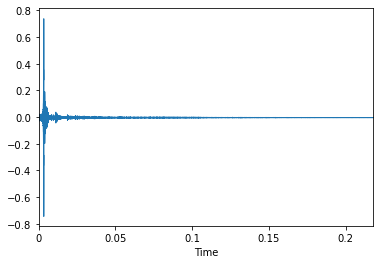

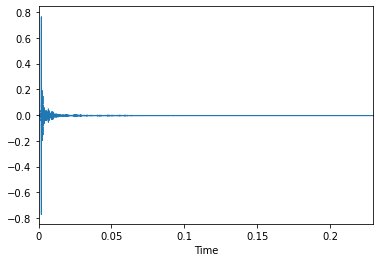

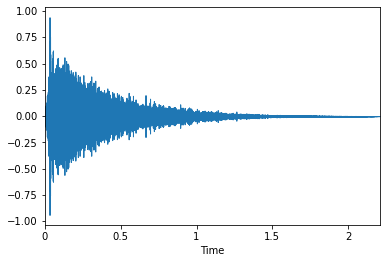

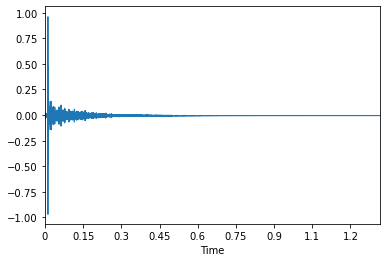

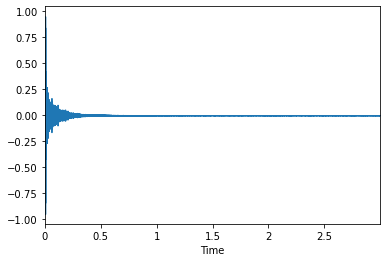

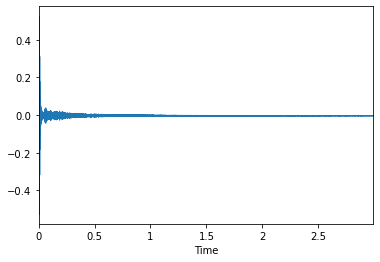

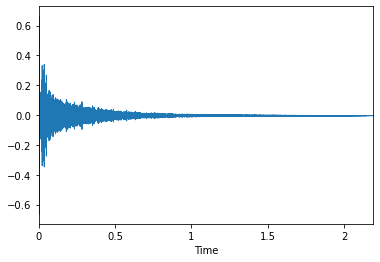

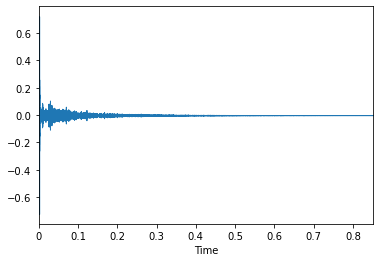

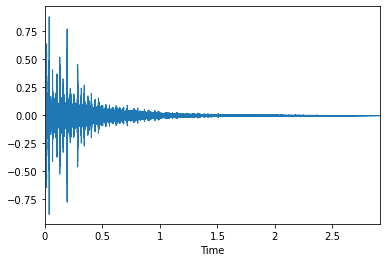

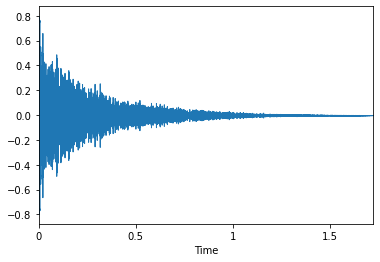

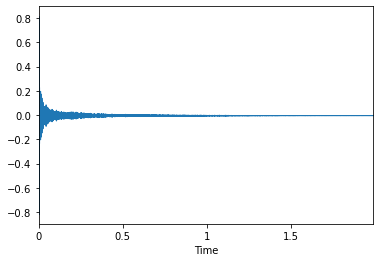

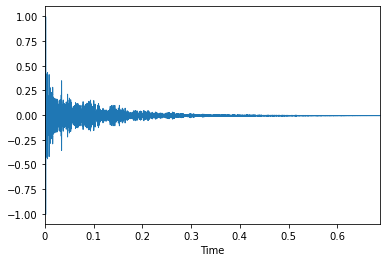

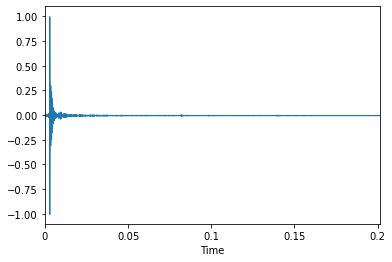

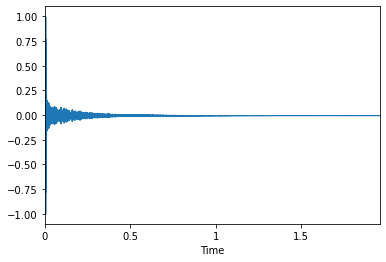

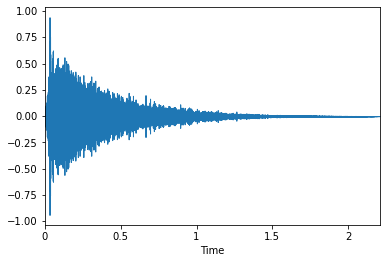

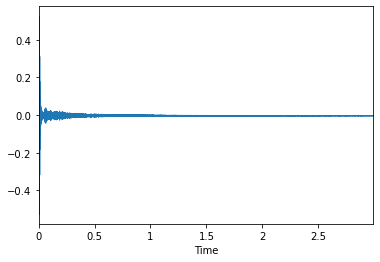

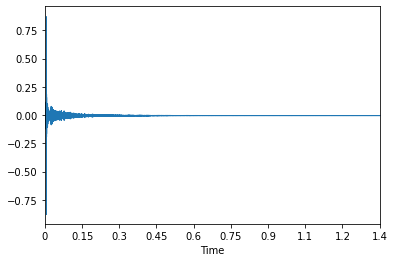

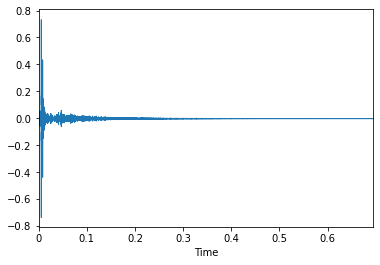

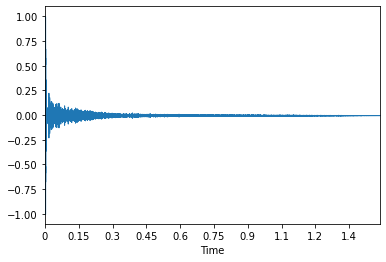

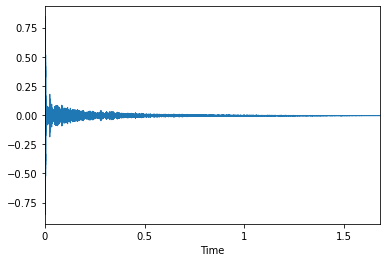

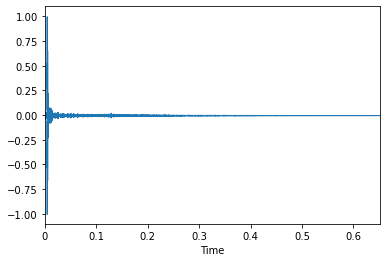

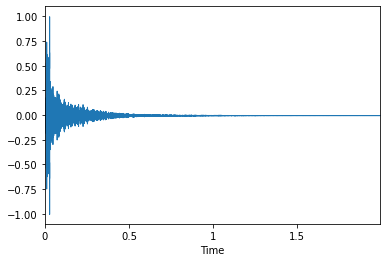

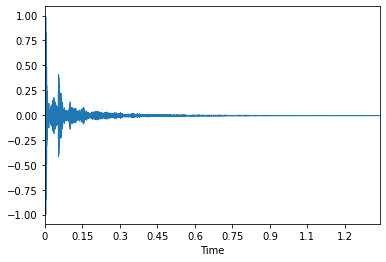

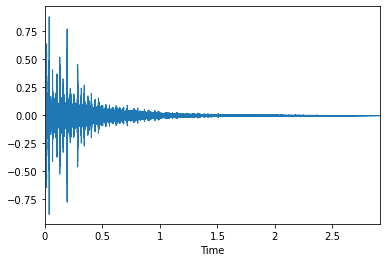

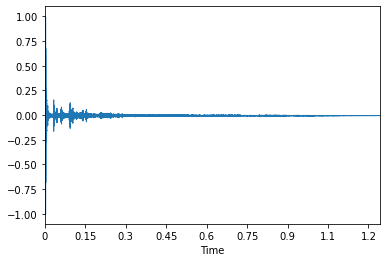

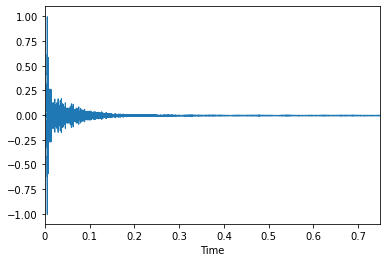

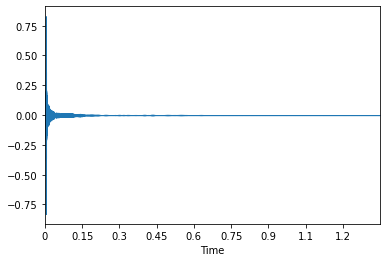

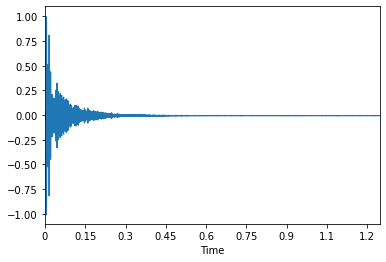

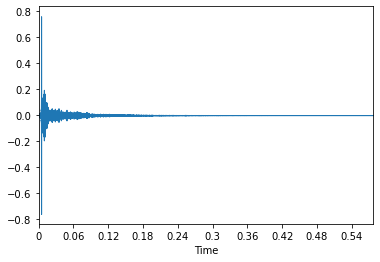

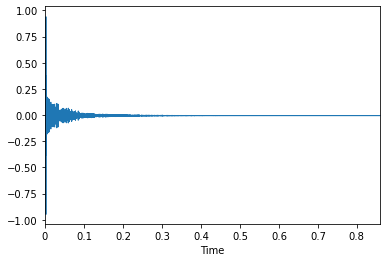

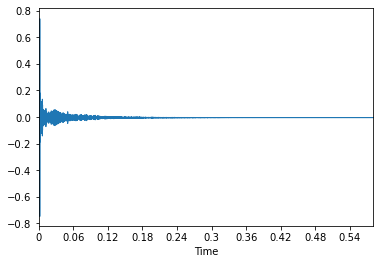

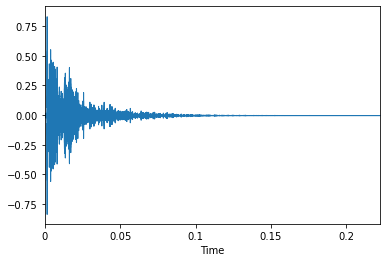

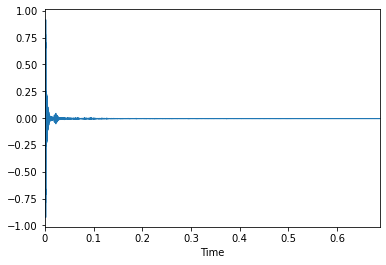

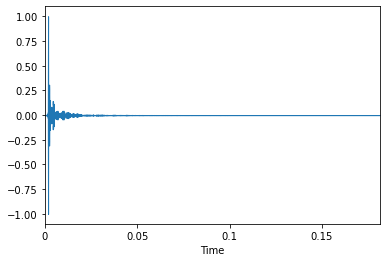

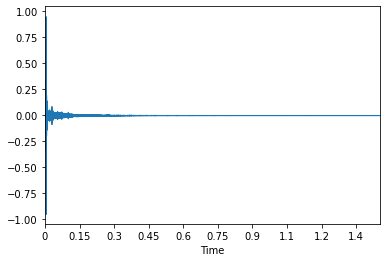

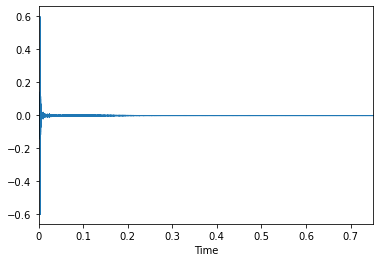

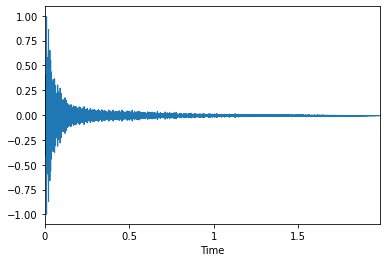

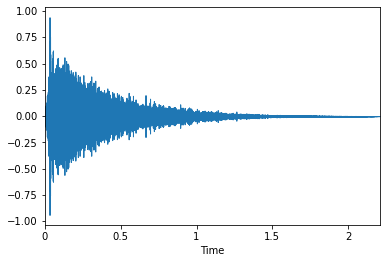

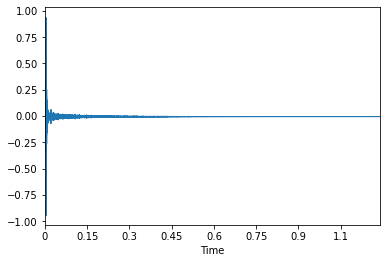

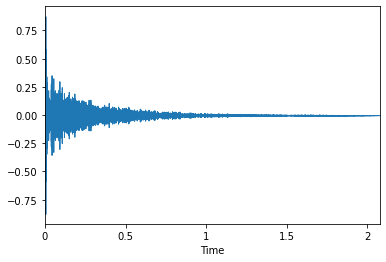

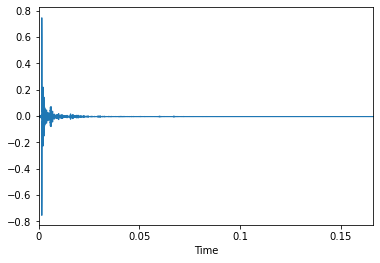

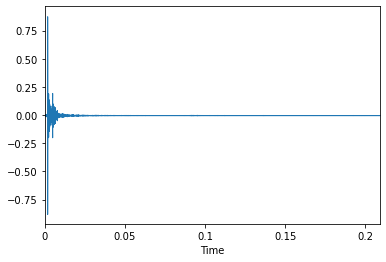

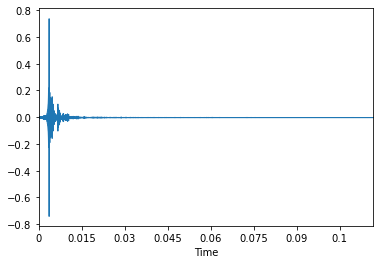

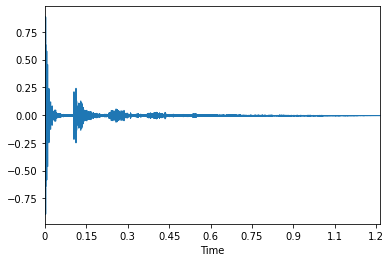

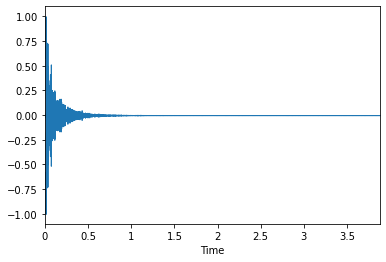

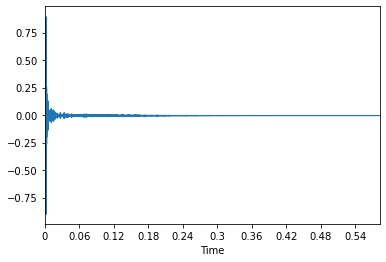

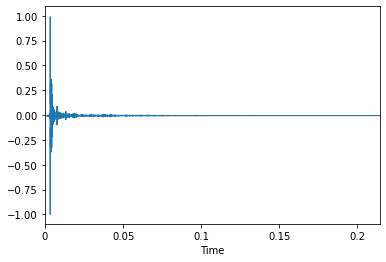

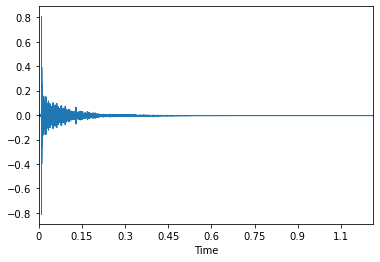

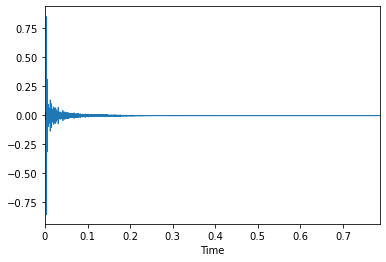

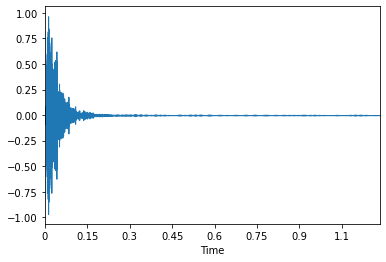

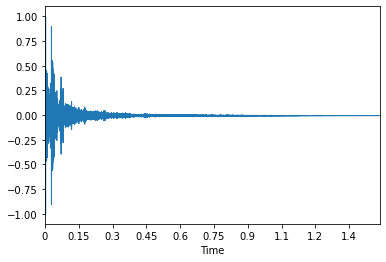

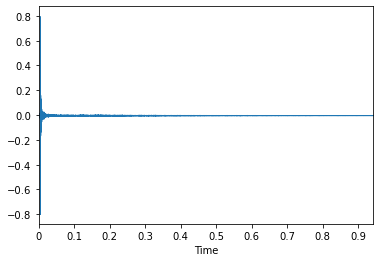

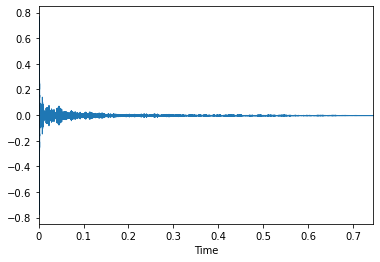

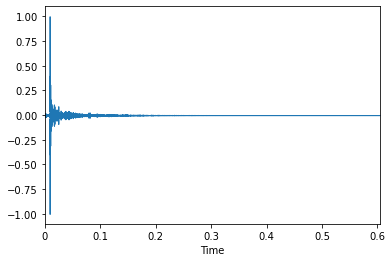

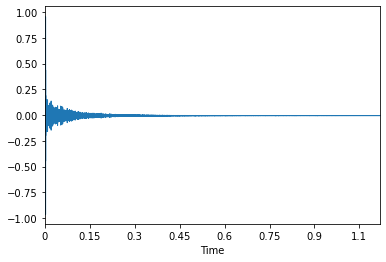

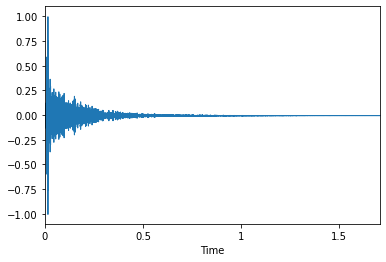

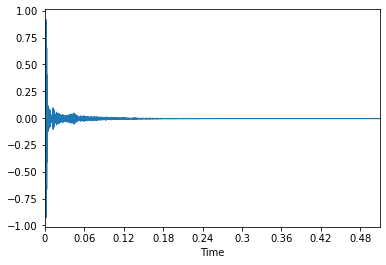

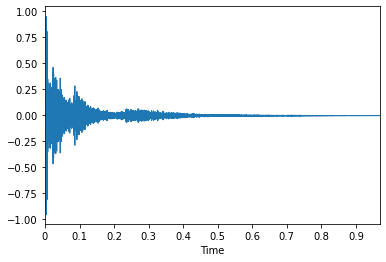

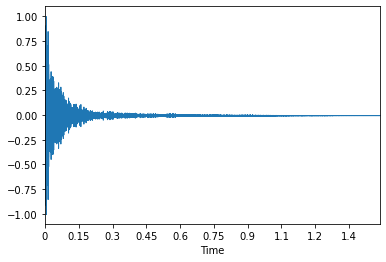

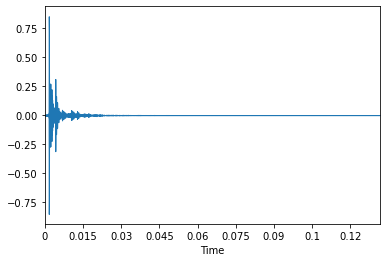

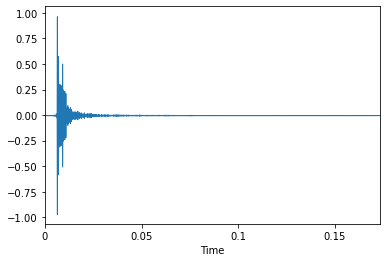

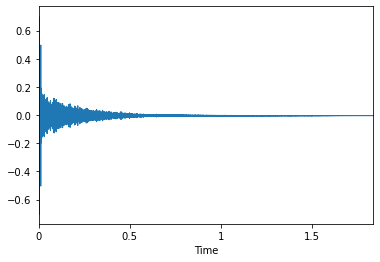

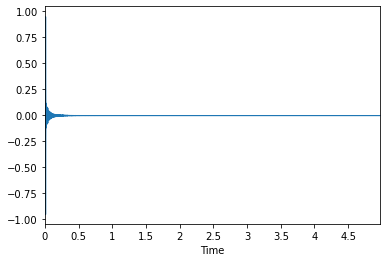

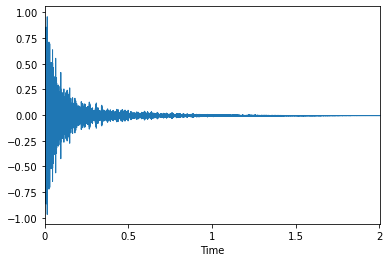

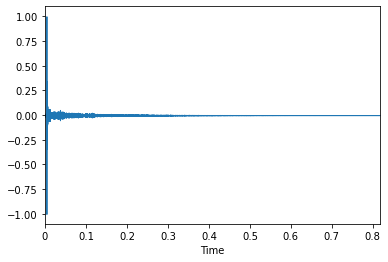

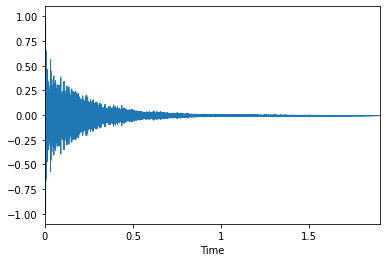

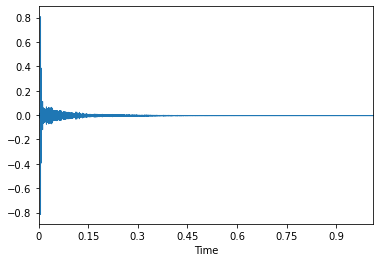

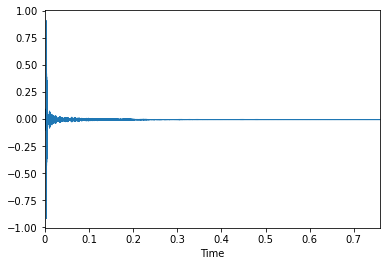

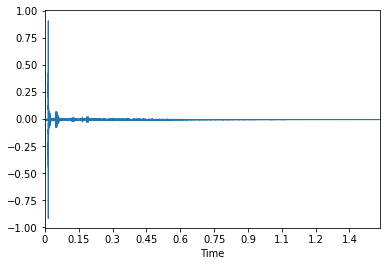

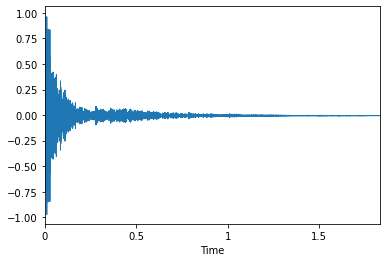

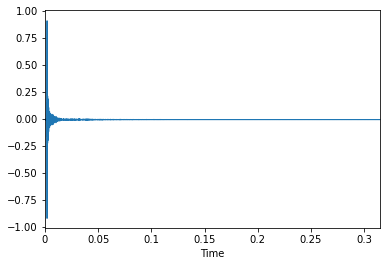

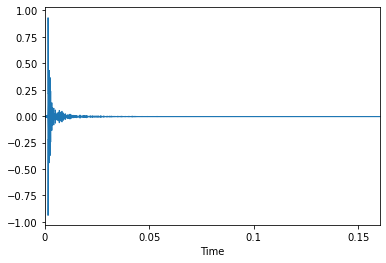

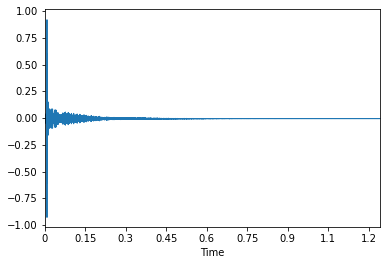

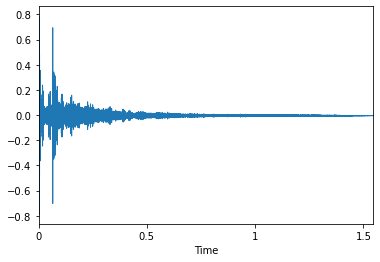

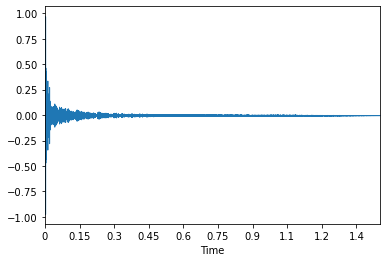

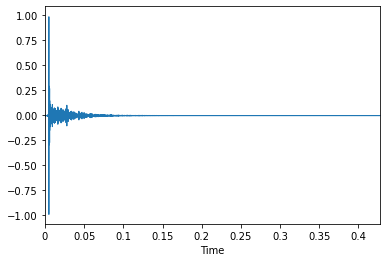

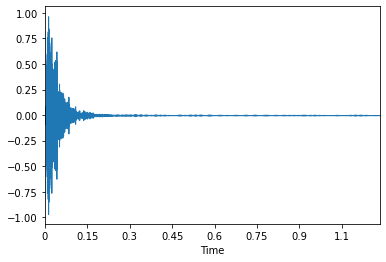

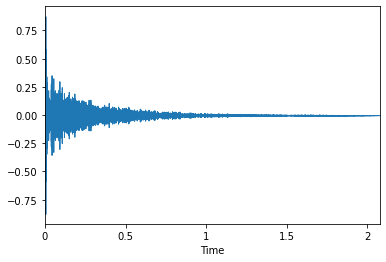

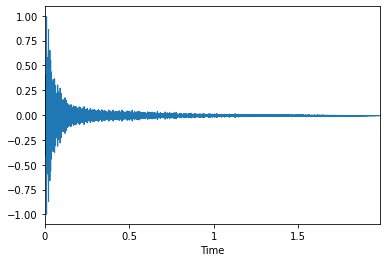

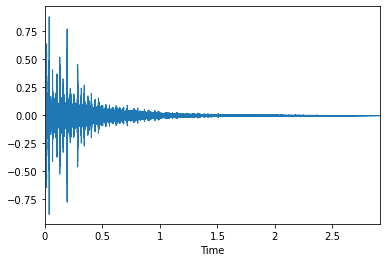

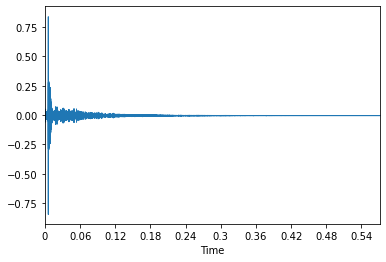

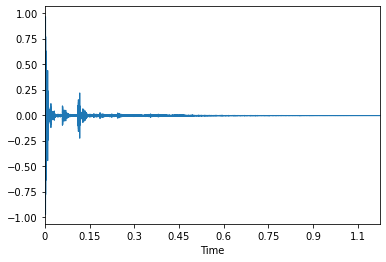

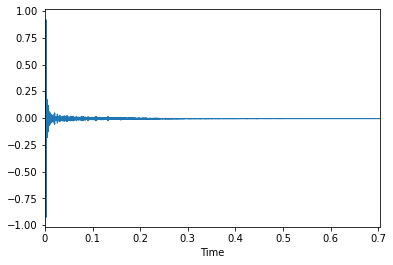

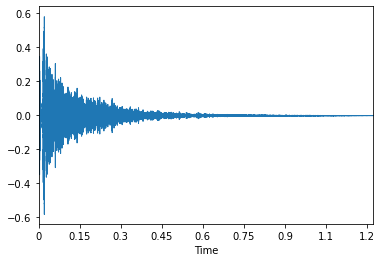

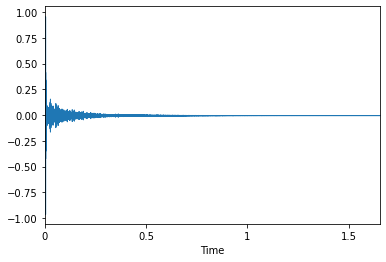

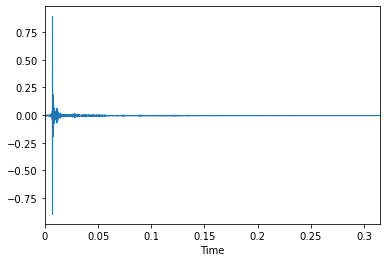

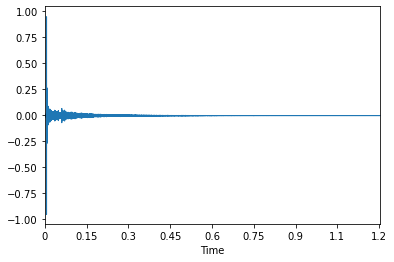

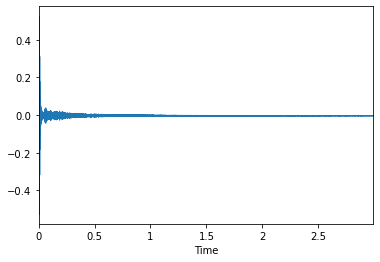

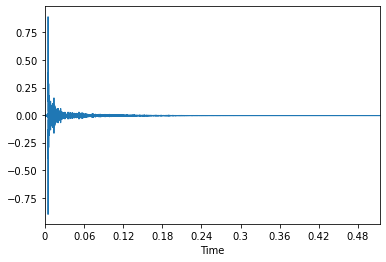

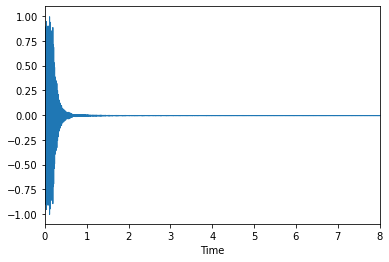

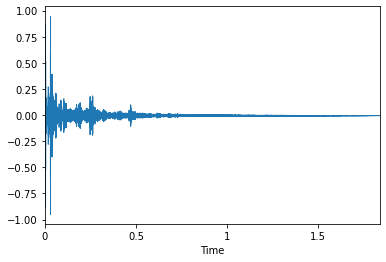

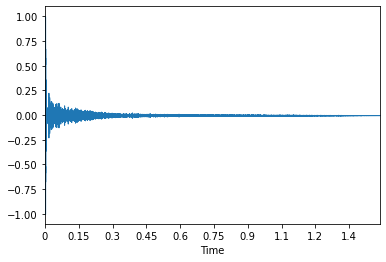

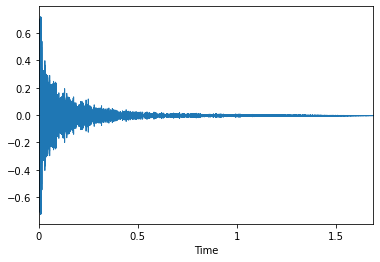

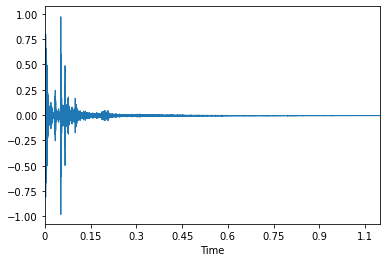

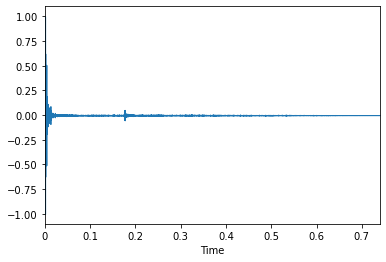

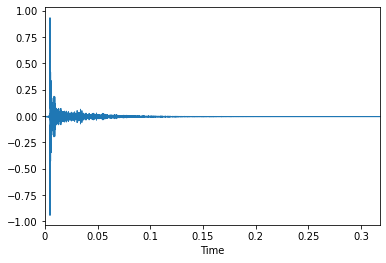

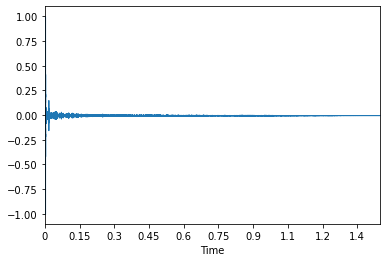

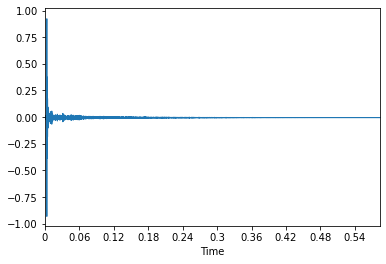

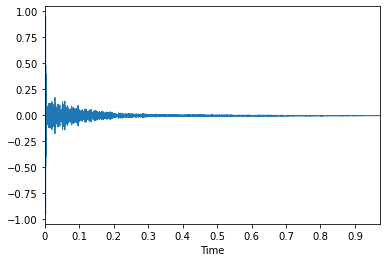

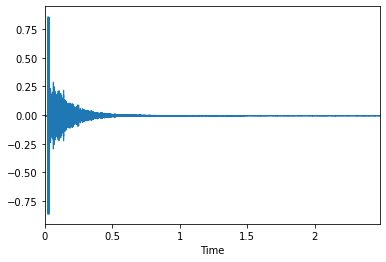

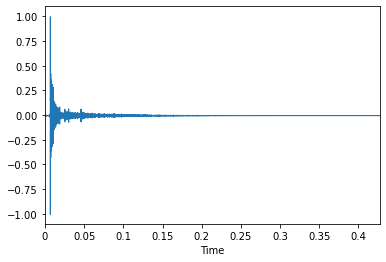

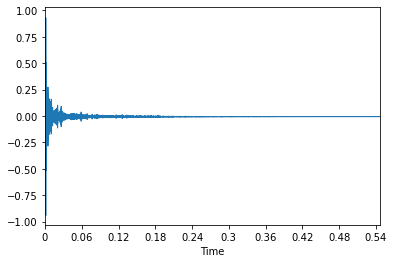

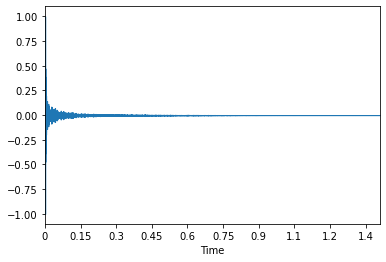

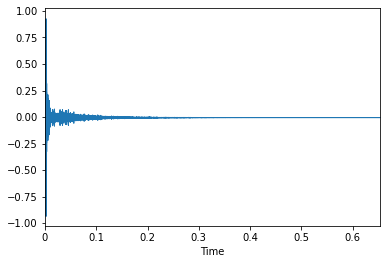

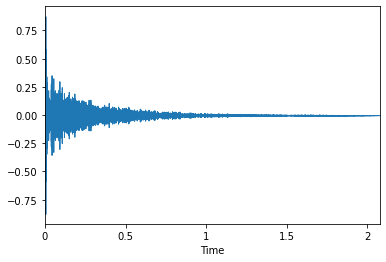

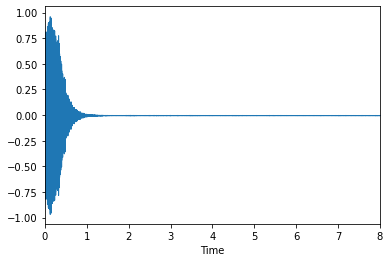

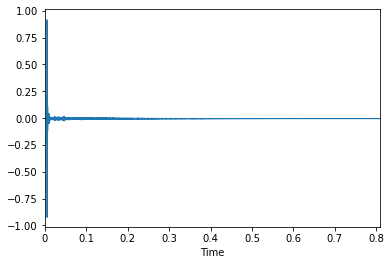

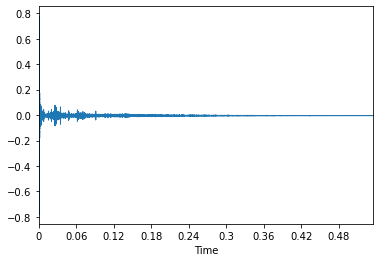

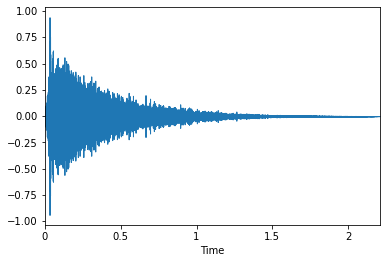

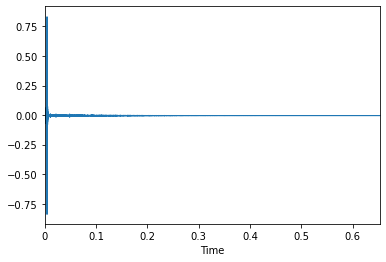

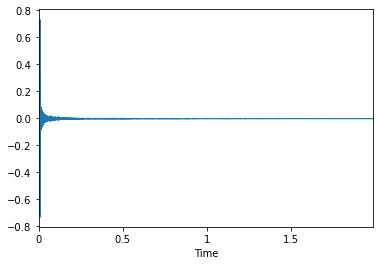

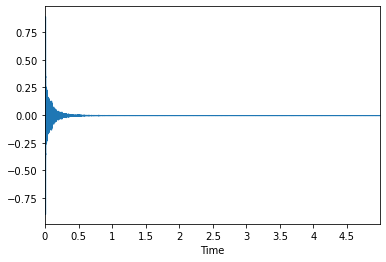

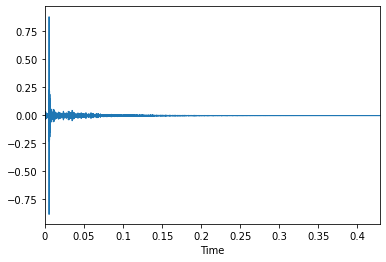

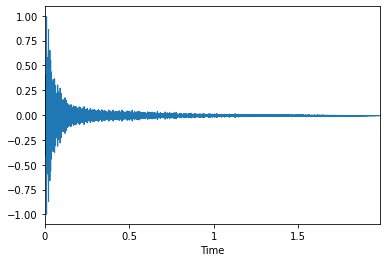

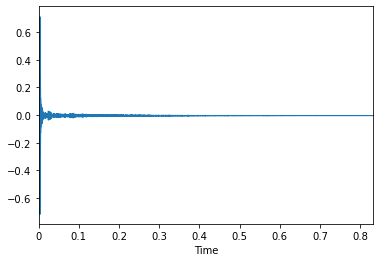

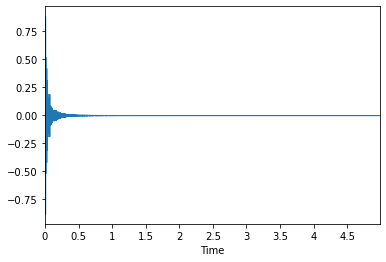

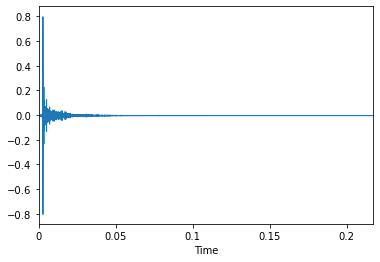

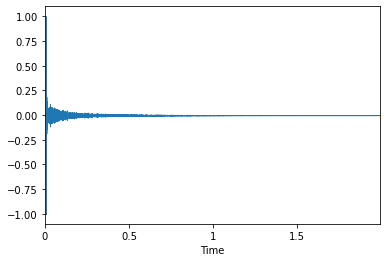

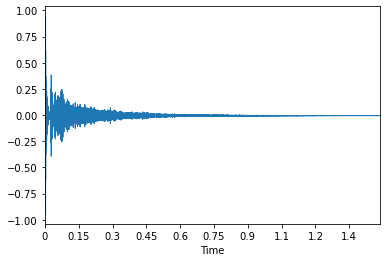

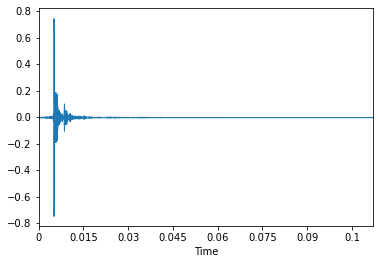

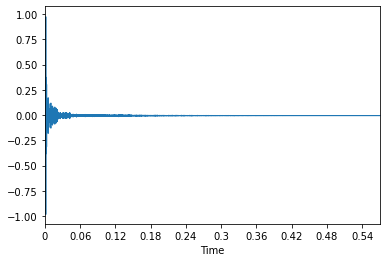

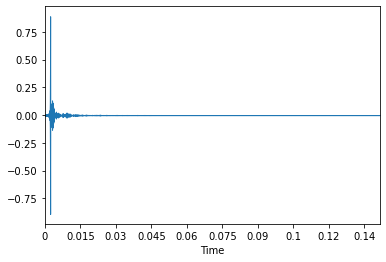

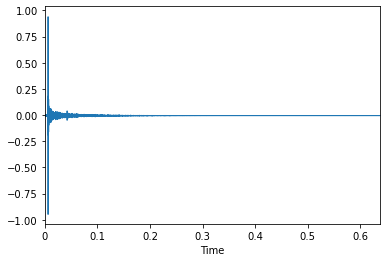

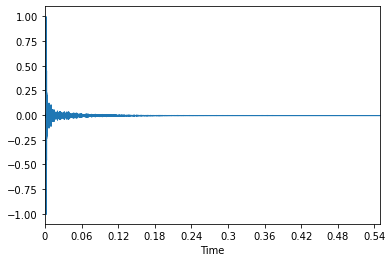

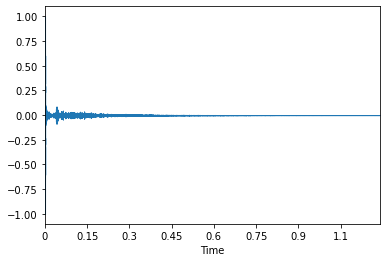

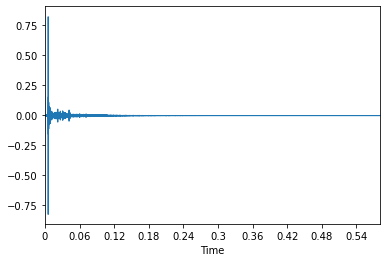

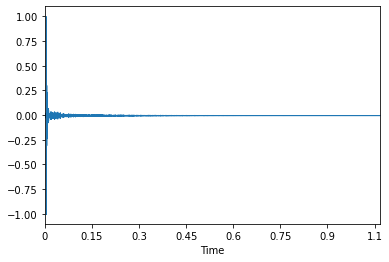

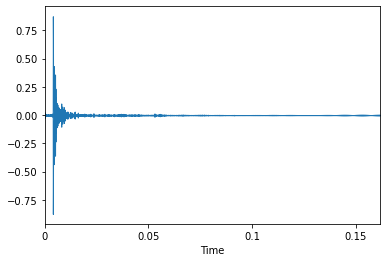

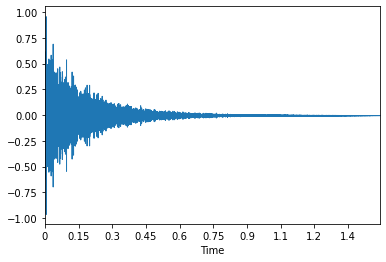

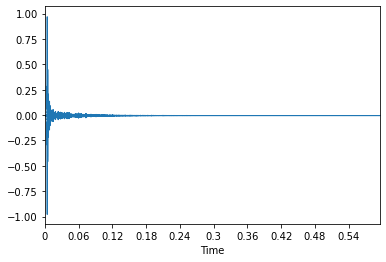

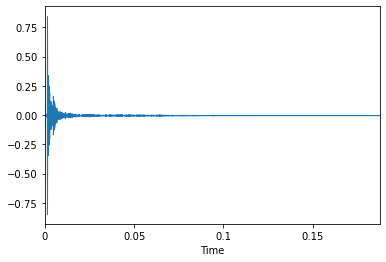

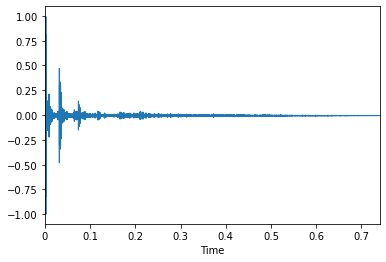

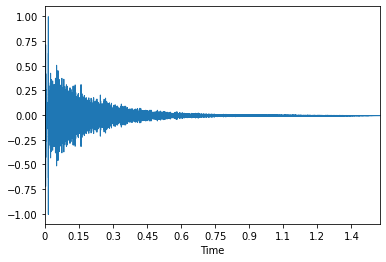

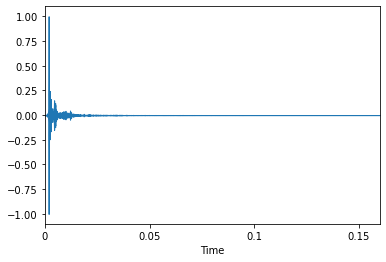

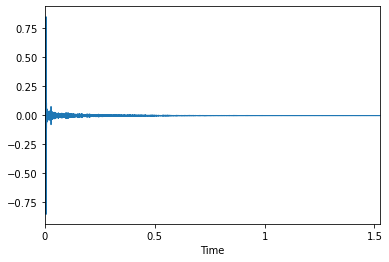

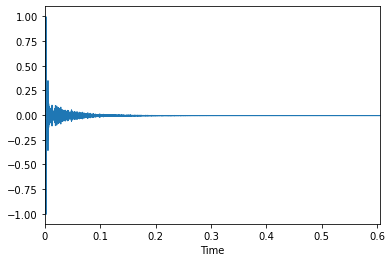

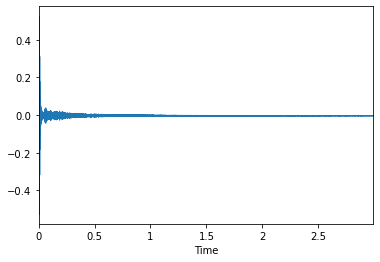

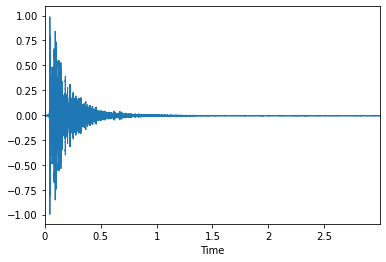

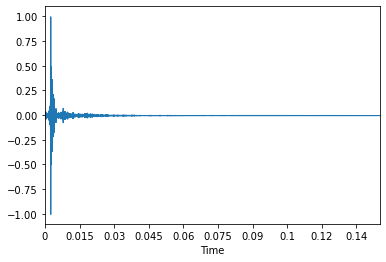

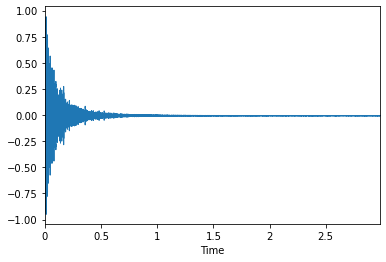

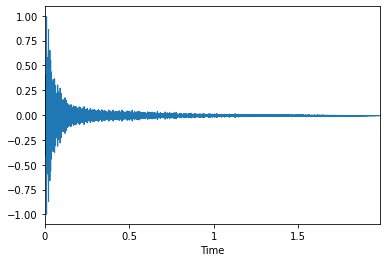

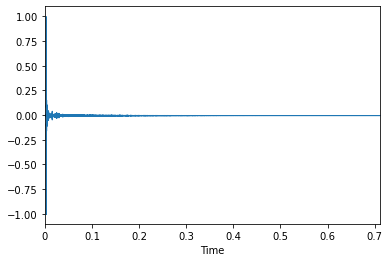

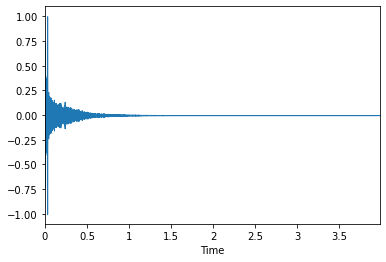

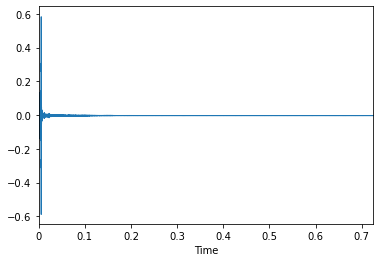

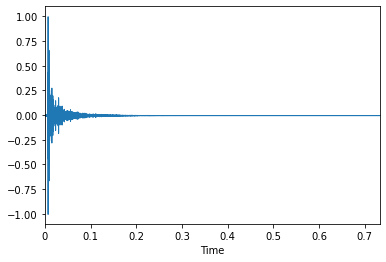

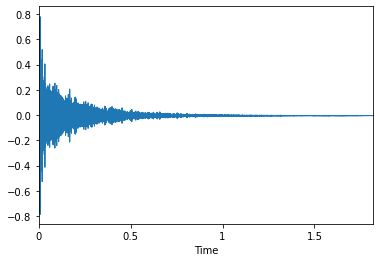

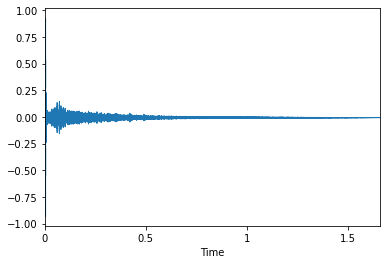

In [11]:
import glob
import librosa
from librosa import display
import matplotlib.pyplot as plt
for rir in glob.glob(os.path.join(balanced_dir,'*')):
    fs, rir_sig = wavfile.read(rir)
    librosa.display.waveplot(rir_sig,fs)
    plt.show()

In [34]:
rir_subset_min1 = rir_dataset[rir_dataset['t60']<1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84a73df890>,
      dtype=object)

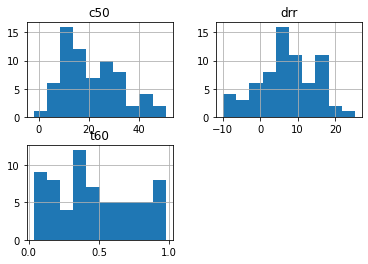

In [35]:
rir_subset_min1.hist()

In [36]:
from progressbar import progressbar

In [37]:
list_rir_subset_min1 = sorted(rir_subset_min1.RIR_name.values)

In [41]:
for db in ['0db','5db','10db','15db']:
    cp_dir = 'datasets/thesis/test/music/'+db+'/mfcc/'
    out_dir = os.path.join('datasets/thesis/test/music/'+db+'/mfcc_1s/')
    if not os.path.exists(out_dir): os.makedirs(out_dir)
    for rir in progressbar(list_rir_subset_min1):
        filename = os.path.splitext(rir)[0]
        run(['cp','-r',cp_dir+filename,out_dir])

100% (68 of 68) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (68 of 68) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (68 of 68) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (68 of 68) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
